In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import imageio

from scipy import ndimage
from scipy import stats
from scipy.spatial import distance

from IPython import display

/tmp/ipykernel_3920/2504689333.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(URL)/255.


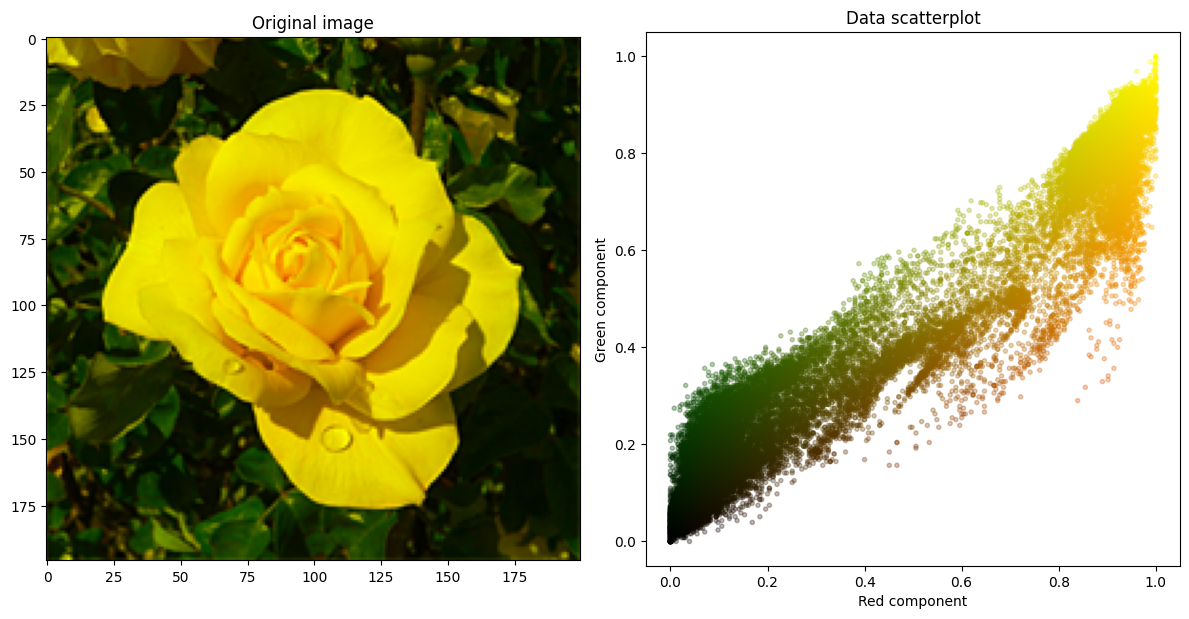

In [2]:
URL = 'https://github.com/janchorowski/nn_assignments/raw/nn17_fall/lecture_notebooks/11-Rosa_Gold_Glow_2_small_noblue.png'
img = imageio.imread(URL)/255.

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(img)
plt.grid(False)
plt.title('Original image')
im_flat = img.reshape([-1, 3])
plt.subplot(122)
plt.title('Data scatterplot')
plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.xlabel('Red component')
plt.ylabel('Green component')
plt.axis('square')
plt.tight_layout()
None

In [3]:
N, D = im_flat.shape

Iteration: 0 Loss: 105.93
Iteration: 10 Loss: 81.5652
Iteration: 20 Loss: 77.5324
Iteration: 30 Loss: 76.3416
Iteration: 40 Loss: 75.8123
Iteration: 50 Loss: 75.3455
Iteration: 60 Loss: 75.2521


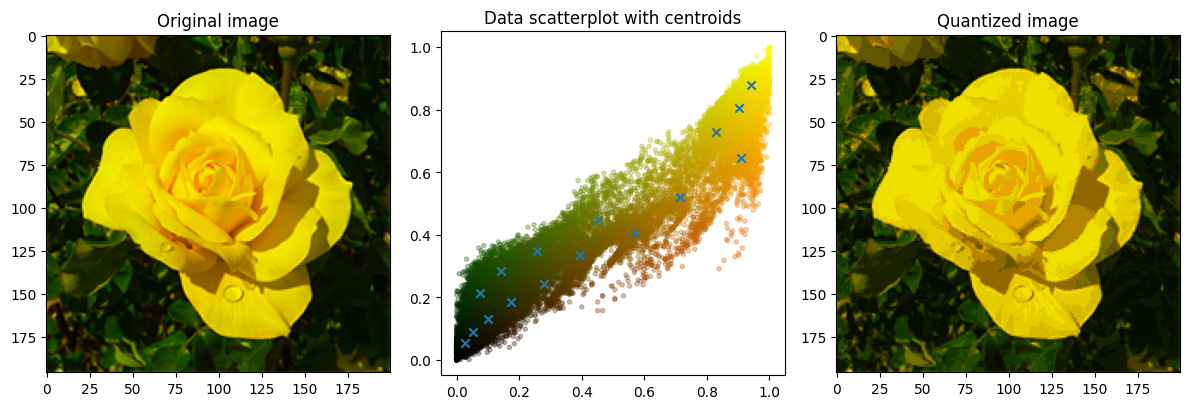

In [4]:
K = 16
initial_center_ids = np.random.choice(N, (K,), replace=False)
centers = im_flat[initial_center_ids, :]

old_loss = np.inf
for i in range(10000):
    center_to_cluster_dists = distance.cdist(centers, im_flat)
    cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
    for k in range(K):
        centers[k] = im_flat[cluster_assignment==k].mean(axis=0)
    loss = ((centers[cluster_assignment] - im_flat)**2).sum()
    if not i%10:
        print ("Iteration: %d Loss: %g" % (i, loss))
    if loss >= old_loss:
        break
    old_loss = loss

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title('Original image')
plt.imshow(img)
plt.grid(False)

plt.subplot(132)
plt.title('Data scatterplot with centroids')
plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.scatter(centers[:,0], centers[:,1], marker='x')
plt.axis('square')

plt.subplot(133)
center_to_cluster_dists = distance.cdist(centers, im_flat)
cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
plt.title('Quantized image')
plt.imshow(centers[cluster_assignment].reshape(img.shape))
plt.grid(False)
plt.tight_layout()

# online k-means

Iteration: 900000 Loss: 73.4583


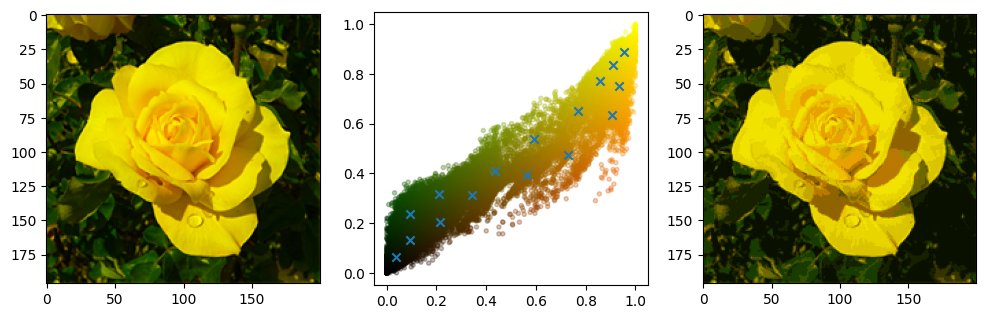

In [5]:
# An on-line version of k-Means

K = 16
initial_center_ids = np.random.choice(N, (K,), replace=False)
centers = im_flat[initial_center_ids, :]

def make_plot():
    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(img)
    plt.grid(False)

    plt.subplot(132)
    plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
    plt.scatter(centers[:,0], centers[:,1], marker='x')
    plt.axis('square')

    plt.subplot(133)
    center_to_cluster_dists = distance.cdist(centers, im_flat)
    cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
    plt.imshow(centers[cluster_assignment].reshape(img.shape))
    plt.grid(False)
    plt.show()

alpha = 1e-2
for i in range(1000000):
    sampled_x = im_flat[np.random.randint(N)]
    cluster_id = np.argmin(((centers - sampled_x)**2).sum(axis=1))
    # centers[cluster_id] = centers[cluster_id] - alpha * (centers[cluster_id] - sampled_x)
    # or equivalently
    centers[cluster_id] = (1 - alpha) * centers[cluster_id] + alpha * sampled_x
    
    if not i%100000:
        center_to_cluster_dists = distance.cdist(centers, im_flat)
        cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
        loss = ((centers[cluster_assignment] - im_flat)**2).sum()
        display.clear_output()
        print ("Iteration: %d Loss: %g" % (i, loss))
        make_plot()
    

#### Kohonen maps

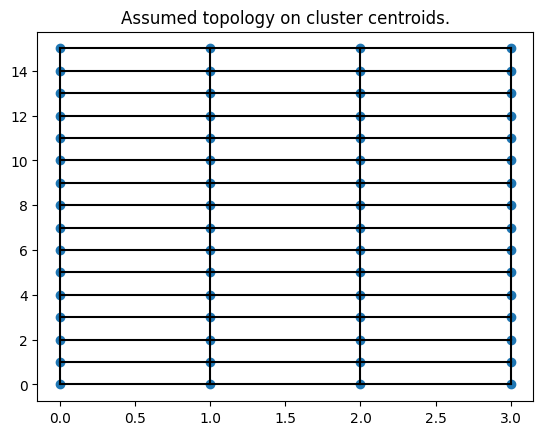

In [12]:
# Kohonen map

# First create a topology between units.
# This has nothing to do with the data we want to quantize!

NY, NX = np.meshgrid(np.arange(4), np.arange(16))
centroid_topology = np.stack([NY.ravel(), NX.ravel()], axis=1)

K = centroid_topology.shape[0]

C = np.zeros((K, K))
for ni in range(K):
    for nj in range(K):
        # C[ni, nj] = np.maximum(0.0, 
        #                        1.0 - np.abs(centroid_topology[ni] - centroid_topology[nj]).sum()/2.0)
        C[ni, nj] = np.maximum(0.0,
                               1.0-np.abs(centroid_topology[ni]-centroid_topology[nj]).sum()/2)

def plot_lines(C, locations, **kwargs):
    segments = []
    for ni, nj in zip(*np.nonzero(C)):
        if ni < nj:
            segments.append(locations[ni])
            segments.append(locations[nj])
            segments.append(np.zeros((2,)) + np.nan)
    segments = np.array(segments)
    plt.plot(segments[:,0], segments[:,1], **kwargs)

plt.title("Assumed topology on cluster centroids.")
plt.scatter(centroid_topology[:,0], centroid_topology[:,1])
plot_lines(C, centroid_topology, color='k')

Iteration: 2900000 Loss: 27.041


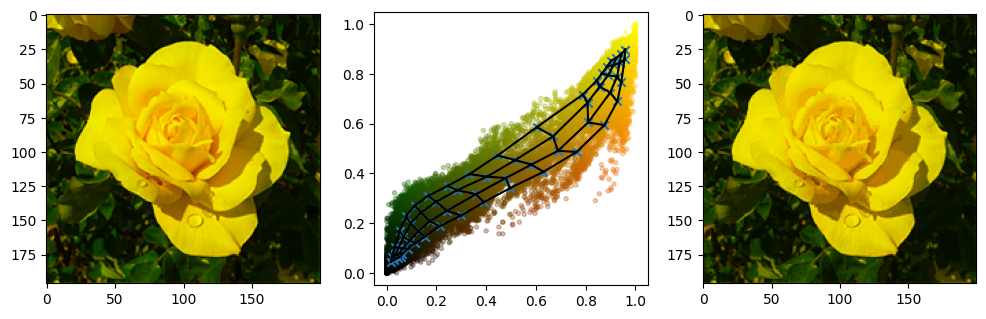

In [13]:
# Kohonen map

# First create a topology between units.
# This has nothing to do with the data we want to quantize!

def make_plot():
    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(img)
    plt.grid(False)

    plt.subplot(132)
    plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
    plt.scatter(centers[:,0], centers[:,1], marker='x')
    plot_lines(C, centers[:,:2], color='k')
    plt.axis('square')

    plt.subplot(133)
    center_to_cluster_dists = distance.cdist(centers, im_flat)
    cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
    plt.imshow(centers[cluster_assignment].reshape(img.shape))
    plt.grid(False)
    plt.show()

initial_center_ids = np.random.choice(N, (K,), replace=False)
centers = im_flat[initial_center_ids, :]

alpha = 2e-2
for i in range(3000000):
    sampled_x = im_flat[np.random.randint(N)]
    cluster_id = np.argmin(((centers - sampled_x)**2).sum(axis=1))
    cluster_alpha = (alpha * C[cluster_id]).reshape([-1, 1])
    centers = (1 - cluster_alpha) * centers + cluster_alpha * sampled_x
    
    if not i%100000:
        center_to_cluster_dists = distance.cdist(centers, im_flat)
        cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
        loss = ((centers[cluster_assignment] - im_flat)**2).sum()
        display.clear_output(wait=True)
        print ("Iteration: %d Loss: %g" % (i, loss))
        make_plot()